# Parameters:

In [1]:
symbol = 'ETHUSDT'
symbol_ask_bid_price_difference = 0.01
checkPointPriceStepRatio = 0.001
kLinesInterval = '1s'

# Environment:

In [2]:
!pip install pandas
!pip install matplotlib

import datetime as dt

import matplotlib.dates as dates
import matplotlib.pyplot as plot
import pandas as pd

You should consider upgrading via the '/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/.venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/.venv/bin/python -m pip install --upgrade pip' command.


# K-lines

/Users/nikita/Documents/projects/things-team/to-the-moon/ttm-analytics/src/chart/ttm_chart.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=60)


,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1677628800000,1605.24,1605.47,1605.23,1605.47,7.9272,1677628800999,12725.338503,34,7.0694,11348.217718,0
1,1677628801000,1605.46,1605.46,1605.46,1605.46,0.4193,1677628801999,673.169378,5,0.0000,0.000000,0
2,1677628802000,1605.46,1605.47,1605.46,1605.46,1.8458,1677628802999,2963.359645,10,0.1577,253.182619,0
3,1677628803000,1605.46,1605.47,1605.46,1605.47,0.7839,1677628803999,1258.525272,13,0.5178,831.312366,0
4,1677628804000,1605.47,1605.47,1605.46,1605.46,0.1706,1677628804999,273.891924,2,0.0448,71.925056,0
...,...,...,...,...,...,...,...,...,...,...,...,...
86395,1677715195000,1665.22,1665.22,1665.22,1665.22,7.9462,1677715195999,13232.171164,6,0.0000,0.000000,0
86396,1677715196000,1665.23,1665.23,1665.23,1665.23,0.1200,1677715196999,199.827600,1,0.1200,199.827600,0
86397,1677715197000,1665.23,1665.23,1665.23,1665.23,0.0000,1677715197999,0.000000,0,0.0000,0.000000,0
86398,1677715198000,1665.22,1665.22,1665.22,1665.22,1.4100,1677715198999,2347.960200,1,0.0000,0.000000,0


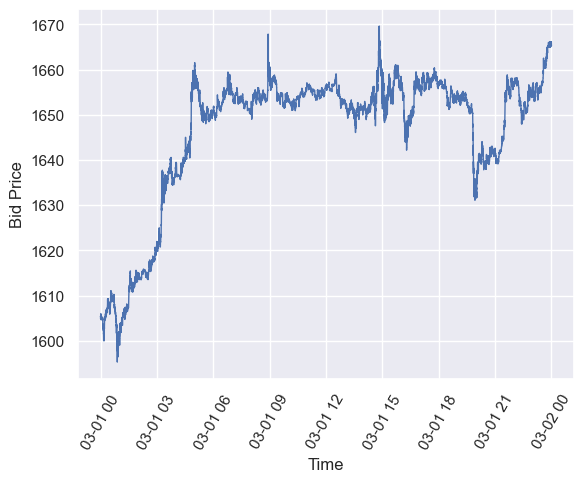

In [3]:
from binance.binance_k_line_loader import load_binance_k_lines
from chart.ttm_chart import draw_line_chart

# https://www.binance.com/en/support/faq/how-to-download-historical-market-data-on-binance-5810ae42176b4770b880ce1f14932262
k_lines = load_binance_k_lines(f"../../../ttm-data/ETHUSDT-1s-2023-03-01.csv")
# k_lines = load_binance_k_lines(f"../ttm-data/{symbol}-{kLinesInterval}-*.csv")

draw_line_chart(k_lines.open_timestamp_millis, k_lines.open_price, name='Bid Price')
k_lines

# Ticks:

In [4]:
kLines = k_lines.iterrows()

ticks = []

for kLineIndex, kLine in kLines:
    kLineOpenTimestampMillis = kLine.open_timestamp_millis
    kLineOpenPrice = kLine.open_price

    tickTimestampMillis = kLineOpenTimestampMillis
    tickTimestampSeconds = int(tickTimestampMillis / 1000)
    tickPrice = kLineOpenPrice

    tick = {}
    tick["timestampSeconds"] = tickTimestampSeconds
    tick["bidPrice"] = tickPrice
    tick["askPrice"] = tickPrice + symbol_ask_bid_price_difference

    ticks.append(tick)

ticksDataFrame = pd.DataFrame(ticks)

ticksDataFrame.head(10)

,timestampSeconds,bidPrice,askPrice
0,1677628800,1605.24,1605.25
1,1677628801,1605.46,1605.47
2,1677628802,1605.46,1605.47
3,1677628803,1605.46,1605.47
4,1677628804,1605.47,1605.48
5,1677628805,1605.46,1605.47
6,1677628806,1605.35,1605.36
7,1677628807,1605.34,1605.35
8,1677628808,1605.21,1605.22
9,1677628809,1605.21,1605.22


# Ticks price:

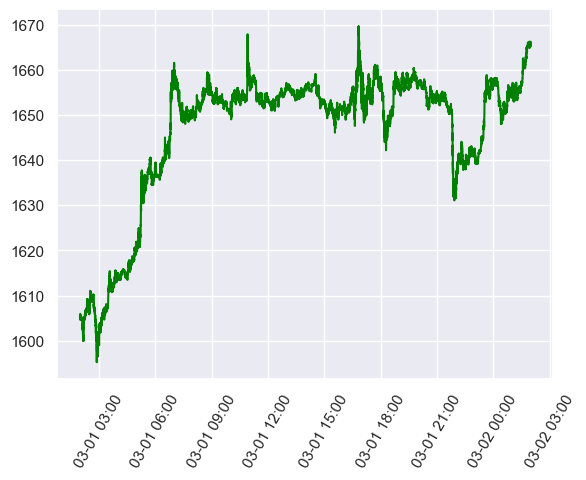

In [5]:
ticksPlotFigure = plot.figure()
ticksPlotAxes = ticksPlotFigure.add_subplot()
ticksPlotAxes.xaxis.set_major_formatter(dates.DateFormatter('%m-%d %H:%M'))
plot.xticks(rotation=60)

tickDateTimes = [dt.datetime.fromtimestamp(timestampSeconds) for timestampSeconds in ticksDataFrame.timestampSeconds]

ticksPlotAxes.plot(tickDateTimes, ticksDataFrame.bidPrice, color='green')


In [6]:
orders = []

checkPoint = None


def createCheckPoint(tick):
    checkPoint = {}
    checkPoint['tick'] = tick
    checkPoint['priceStep'] = tick['bidPrice'] * checkPointPriceStepRatio
    checkPoint['fallStepAskPrice'] = checkPoint["tick"]["bidPrice"] - checkPoint['priceStep']
    checkPoint['growStepBidPrice'] = checkPoint["tick"]["askPrice"] + checkPoint['priceStep']
    return checkPoint


def createOrder(tick, orderType):
    order = {}
    order['openTimestampSeconds'] = tick['timestampSeconds']
    order['openAskPrice'] = tick['askPrice']
    order['openBidPrice'] = tick['bidPrice']
    order['type'] = orderType
    # print(f"{orderType} order opened")
    return order


def closeOrder(order, tick):
    order['closeTimestampSeconds'] = tick['timestampSeconds']
    order['closeAskPrice'] = tick['askPrice']
    order['closeBidPrice'] = tick['bidPrice']
    if order['type'] == 'grow':
        order['profit'] = order['closeBidPrice'] - order['openAskPrice']
    elif order['type'] == 'fall':
        order['profit'] = order['openBidPrice'] - order['closeAskPrice']
        # print(f"Order closed with profit {order['profit']}")


currentOrder = None

for tick in ticks:
    if (checkPoint == None):
        checkPoint = createCheckPoint(tick)
        # print(f'Init check point: {checkPoint["tick"]["askPrice"]} / {checkPoint["tick"]["bidPrice"]} ({checkPoint["priceStep"]})')
        continue

    growStepDetected = tick['bidPrice'] >= checkPoint['growStepBidPrice']
    if (growStepDetected):
        # print(f"\nGrow step: {tick['bidPrice']} >= {checkPoint['growStepBidPrice']}")
        checkPoint = createCheckPoint(tick)
        # print(f'New check point: {checkPoint["tick"]["askPrice"]} / {checkPoint["tick"]["bidPrice"]} ({checkPoint["priceStep"]})')

    if (growStepDetected and currentOrder != None):
        closeOrder(currentOrder, tick)
        orders.append(currentOrder)
        currentOrder = None

    if (growStepDetected and currentOrder == None):
        currentOrder = createOrder(tick, 'fall')

    fallStepDetected = tick["askPrice"] <= checkPoint['fallStepAskPrice']
    if (fallStepDetected):
        # print(f"\nFall step: {tick['askPrice']} <= {checkPoint['fallStepAskPrice']}")
        checkPoint = createCheckPoint(tick)
        # print(f'New check point: {checkPoint["tick"]["askPrice"]} / {checkPoint["tick"]["bidPrice"]} ({checkPoint["priceStep"]})')

    if (fallStepDetected and currentOrder != None):
        closeOrder(currentOrder, tick)
        orders.append(currentOrder)
        currentOrder = None

    if (fallStepDetected and currentOrder == None):
        currentOrder = createOrder(tick, 'grow')


In [13]:
ordersDataFrame = pd.DataFrame(orders)

ordersDataFrame.head(46)

,openTimestampSeconds,openAskPrice,openBidPrice,type,closeTimestampSeconds,closeAskPrice,closeBidPrice,profit
0,1677629231,1603.36,1603.35,grow,1677629370,1601.49,1601.48,-1.88
1,1677629370,1601.49,1601.48,grow,1677629547,1603.29,1603.28,1.79
2,1677629547,1603.29,1603.28,fall,1677629568,1605.15,1605.14,-1.87
3,1677629568,1605.15,1605.14,fall,1677629857,1606.81,1606.80,-1.67
4,1677629857,1606.81,1606.80,fall,1677630140,1608.50,1608.49,-1.70
5,1677630140,1608.50,1608.49,fall,1677630526,1606.88,1606.87,1.61
6,1677630526,1606.88,1606.87,grow,1677630704,1608.50,1608.49,1.61
7,1677630704,1608.50,1608.49,fall,1677630739,1610.27,1610.26,-1.78
8,1677630739,1610.27,1610.26,fall,1677631405,1608.64,1608.63,1.62
9,1677631405,1608.64,1608.63,grow,1677631497,1607.02,1607.01,-1.63


In [8]:
ordersDataFrame.profit

0     -1.88
1      1.79
2     -1.87
3     -1.67
4     -1.70
       ... 
425   -1.70
426    1.72
427    1.69
428   -1.95
429   -1.76
Name: profit, Length: 430, dtype: float64

In [9]:
profits = []

currentProfit = 0

for order in orders:
    profit = {}
    currentProfit = currentProfit + order['profit']
    profit['value'] = currentProfit
    profit['timestampSeconds'] = order['openTimestampSeconds']
    profits.append(profit)

profitsDataFrame = pd.DataFrame(profits)

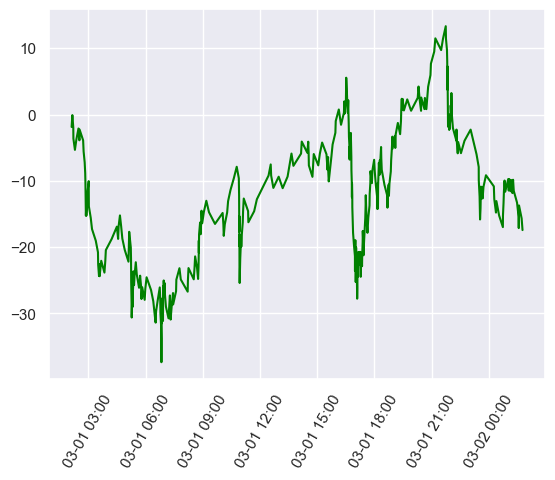

In [10]:
profitPlotFigure = plot.figure()
profitPlotAxes = profitPlotFigure.add_subplot()
profitPlotAxes.xaxis.set_major_formatter(dates.DateFormatter('%m-%d %H:%M'))
plot.xticks(rotation=60)

profitDateTimes = [dt.datetime.fromtimestamp(timestampSeconds) for timestampSeconds in
                   profitsDataFrame.timestampSeconds]

profitPlotAxes.plot(profitDateTimes, profitsDataFrame.value, color='green')

In [11]:
profitsDataFrame.value

0      -1.88
1      -0.09
2      -1.96
3      -3.63
4      -5.33
       ...  
425   -17.13
426   -15.41
427   -13.72
428   -15.67
429   -17.43
Name: value, Length: 430, dtype: float64

In [12]:
profits[len(profits) - 1]['value']


-17.429999999993697